# Lab Assignment Six: Convolutional Network Architectures

### *Michael Han, Andrew Kozelsky, Vince Miller, Ryan Cole*


# Dataset Selection
We select a set of images of a person holding a knife taken from a first person perspective. The images are 100x100 pixels, and consist of 3559 images with and 9340 images without knives. The data was provided by Matiolański et all in the following paper: https://link.springer.com/article/10.1007%2Fs11042-015-2697-z.

For transfer learning, we have also generated a set of images using a video game (Fallout 4).  These frames were taken by moving the player avatar through similar game environments while holding nothing, a knife, or a pistol.  We created this dataset to see if we could successfully apply transfer learning using a network trained on the Matiolański knife images.  We considered using the same method to validate the effectiveness of identifying if an individual was holding a firearm, but concluded that producing images using software might result in indicators that are easily identified by the neural network but would not appear in a real life situation.

# Business Case
Our final goal is to create a system that identifies when a law-enforcement agent using a body worn camera has unholstered their weapon (usually a firearm). This system would identify which sections of footage should closely examined by a human. Given the large amount of data generated by these cameras, a law enforcement agency might be interested in having an efficient and accurate way to review body worn camera footage.  

Since a dataset of pictures of individuals holding firearms was not available, we consider this project that uses photos of knives to be a proof of concept. With this successful test, we propose collecting a set of images that are appropriate to the specific identification goal.  

# Compute Environment
Compuations were performed using an Intel I-7 CPU with 8 GB of RAM, and an Nvidia 960 model graphics card.  CUDA was installed and configured to allow parallel computations to be offloaded to the GPU.

# Preparation

## Evaluation Metric

Because this is a proof of concept, we will evaluate how our model performs by capturing the recall percentage. Recall measures how often do we accurately predict there's a knife within the images when there actually is a knife in the image. 

In [1]:
## from keras old documentation: https://github.com/keras-team/keras/commit/a56b1a55182acf061b1eb2e2c86b48193a0e88f7
### recall was removed from keras metrics
def recall(y_true, y_pred):	
    """Recall metric.	
     Only computes a batch-wise average of recall.	
     Computes the recall, a metric for multi-label classification of	
    how many relevant items are selected.	
    """	
    import keras.backend as K
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))	
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))	
    recall = true_positives / (possible_positives + K.epsilon())	
    return recall


## Training and Testing Splits

We decided the work a stratified shuffle split of our data. Usually, when a law-enforcement agent is on duty there shouldn't be too many knives (or weapons) drawn on them. Our dataset skews more heavily toward images without knives thereby mimicking what the model will go through in production, in theory. Cross validation will also be stratified shuffle 5-fold to capture how our model will perform in production.


## Cross Validation

For convenience sake we describe and implement cross validation in a later section.

# Modeling

In [2]:
import cv2
import os
import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import seaborn as sns

# set working directory to read/save weights and video/image files
os.chdir(r'C:\Machine-Learning-Group\lab6')


In [3]:
neg = [cv2.imread(file) for file in glob.glob(r"C:\Machine-Learning-Group\KnivesImagesDatabase\NEGATIVES_ALL\*.bmp")]
pos = [cv2.imread(file) for file in glob.glob(r"C:\Machine-Learning-Group\KnivesImagesDatabase\POSITIVES_ALL\*.bmp")]

X = np.concatenate([neg, pos], axis = 0) # concatenate all images into one np.array

print('Number of Images without knives: ', len(neg))
print('Number of Images with knife: ', len(pos))
print('Number of Images: ', len(X))

Number of Images without knives:  9340
Number of Images with knife:  3559
Number of Images:  12899


In [4]:
# encoding target variable
y = np.zeros(len(X)).astype('object') # creating array 
y[:len(neg)] = 'negative'
y[len(neg):len(pos+neg)] = 'positive'

print('Count of target variable by class')
np.unique(y, return_counts=True)

Count of target variable by class


(array(['negative', 'positive'], dtype=object),
 array([9340, 3559], dtype=int64))

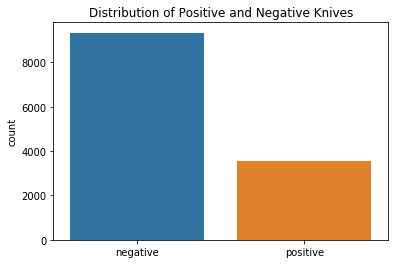

In [5]:
sns.countplot(y)
plt.title('Distribution of Positive and Negative Knives')
plt.show()

Above, we see that our data set is slightly skewed.  It would likely be useful to obtain a data set that was more representative of the setting in the intended domain.  For example, it is unlikely that a law enforcement officer would need to unholster a weapon 30% of the time they wear a body worn camera.

In [6]:
# Shuffle Split for train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle = True, stratify = y, test_size = 0.2, random_state = 42)

print(X_train.shape)
print(X_test.shape)

(10319, 100, 100, 3)
(2580, 100, 100, 3)


We reserve 20% of the data for validation, and use 80% for training.

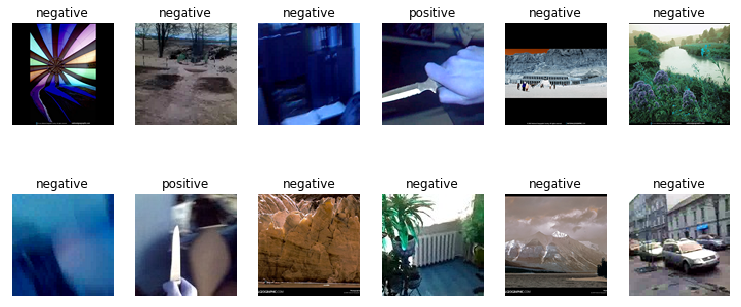

In [7]:
plt.style.use('ggplot')

NUM_CLASSES = 2

# Fixing X_train and X_test sizes based on laron's notebook
img_hw = X[0].shape[0]

# a helper plotting function
def plot_gallery(images, titles, h, w, n_row=3, n_col=6):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.7 * n_col, 2.3 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w,3)), cmap = 'gray')
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

plot_gallery(X_train, y_train, img_hw, img_hw, n_row=2)

Above, images that contain a knife are marked as positive, and images without are marked as negative.  Later, these will be encoded into integers, where 0 indicates negative and 1 indicates positive.

In [8]:
import keras
from keras.layers import Reshape
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping
from keras.regularizers import l2
from keras.layers import average, concatenate, Add
from keras.models import Input, Model

keras.__version__

Using TensorFlow backend.


'2.2.4'

In [9]:
#X_train = np.expand_dims(X_train.reshape((-1,img_h,img_w)), axis=3)

#X_test = np.expand_dims(X_test.reshape((-1,img_h,img_w)), axis=3)

# convert string values to numeric prepresentation
le = LabelEncoder()
y_train_int = le.fit_transform(y_train)
y_test_int = le.fit_transform(y_test)

# use keras one hot enconder
y_train_ohe = keras.utils.to_categorical(y_train_int, NUM_CLASSES)
y_test_ohe = keras.utils.to_categorical(y_test_int, NUM_CLASSES)

In [86]:
## Using Summarize_net from larson's notes
def summarize_net(net, X_test, y_test, title_text=''):
    import sklearn.metrics as mt
    import seaborn as sns
    plt.figure(figsize=(15,5))
    yhat = np.argmax(net.predict(X_test), axis=1)
    recall = mt.recall_score(y_test,yhat)
    cm = mt.confusion_matrix(y_test,yhat)
    cm = cm/np.sum(cm,axis=1)[:,np.newaxis]
    sns.heatmap(cm, annot=True, fmt='.2f')
    plt.title((title_text, recall))
    
#Plot training and validation losses 
def plot_losses(model, model_name):
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.plot(model.history.history['loss'])
    plt.title(model_name + ' Training Loss')
    plt.ylabel('Training Loss')
    plt.xlabel('epochs')
    plt.subplot(1,2,2)
    plt.plot(model.history.history['val_loss'])
    plt.title(model_name + ' Validation Loss')
    plt.ylabel('Validation Loss')
    plt.xlabel('epochs')
    plt.show()
    
def plot_losses_manual(manual_dict, model_name):
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.plot(manual_dict['loss'])
    plt.title(model_name + ' Training Loss')
    plt.ylabel('Training Loss')
    plt.xlabel('epochs')
    plt.subplot(1,2,2)
    plt.plot(manual_dict['val_loss'])
    plt.title(model_name + ' Validation Loss')
    plt.ylabel('Validation Loss')
    plt.xlabel('epochs')
    plt.show()

## AlexNet Style Convolutional Neural Network

In [11]:
# create alexnet inspired neural network
# trainable_lower_layers flag fixes weights for all but the top two layers of the network
def create_alexnet(img_hw=100, l2_lambda=0.0001, trainable_lower_layers=True):
    input_holder = Input(shape=(img_hw,img_hw,3))


    
    x = Conv2D(filters=32, 
                    kernel_size=(3,3), 
                    input_shape = (img_hw,img_hw,3),
                    kernel_initializer='he_uniform',
                    kernel_regularizer=l2(l2_lambda),
                    padding='same', 
                    activation='relu', data_format="channels_last", 
                    trainable=trainable_lower_layers)(input_holder)

    x = Conv2D(filters=32,
                    kernel_size=(3,3), 
                    kernel_initializer='he_uniform',
                    kernel_regularizer=l2(l2_lambda),
                    padding='same', 
                    activation='relu', 
                    trainable=trainable_lower_layers)(x)
    x = MaxPooling2D(pool_size=(3, 3), data_format="channels_last", 
                     trainable=trainable_lower_layers)(x)

    x = Conv2D(filters=64,
                    kernel_size=(3,3), 
                    kernel_initializer='he_uniform',
                    kernel_regularizer=l2(l2_lambda),
                    padding='same', 
                    activation='relu', 
                    trainable=trainable_lower_layers)(x)
    x = Conv2D(filters=64,
                    kernel_size=(3,3), 
                    kernel_initializer='he_uniform',
                    kernel_regularizer=l2(l2_lambda),
                    padding='same', 
                    activation='relu', 
                    trainable=trainable_lower_layers)(x)
    x = MaxPooling2D(pool_size=(3, 3), data_format="channels_last")(x)

    x = Conv2D(filters=128,
                    kernel_size=(3,3), 
                    kernel_initializer='he_uniform',
                    kernel_regularizer=l2(l2_lambda),
                    padding='same', 
                    activation='relu', 
                    trainable=trainable_lower_layers)(x)
    x = Conv2D(filters=128,
                    kernel_size=(3,3), 
                    kernel_initializer='he_uniform',
                    kernel_regularizer=l2(l2_lambda),
                    padding='same', 
                    activation='relu', 
                    trainable=trainable_lower_layers)(x)


    # add one layer on flattened output
    x = Dropout(0.25)(x) # add some dropout for regularization after conv layers
    x = Flatten()(x)
    x = Dense(128, 
              activation='relu',
              kernel_initializer = 'he_uniform',
              kernel_regularizer = l2(l2_lambda))(x)

    x = Dropout(0.5)(x) # add some dropout for regularization, again!
    x = Dense(NUM_CLASSES, 
              activation='softmax',
              kernel_initializer = 'glorot_uniform',
              kernel_regularizer = l2(l2_lambda))(x)

    return Model(inputs = input_holder, outputs = x)

Here we create alexnet and train on raw Matiolański dataset

In [12]:
alexnet_raw = create_alexnet()
alexnet_raw.summary()
# Training model
alexnet_raw.compile(loss='categorical_crossentropy', # 'categorical_crossentropy' 'mean_squared_error'
              optimizer='rmsprop', # 'adadelta' 'rmsprop'
              metrics=[recall])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100, 100, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 100, 100, 32)      896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 100, 100, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 33, 33, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 33, 33, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 33, 33, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 11, 11, 64)        0         
__________

In [13]:
alexnet_raw.fit(X_train, y_train_ohe, 
        batch_size=128, 
        epochs=50, 
        shuffle=True, verbose=1, 
        validation_data=(X_test,y_test_ohe),
        callbacks=[EarlyStopping(monitor='val_loss', patience=4)])

Train on 10319 samples, validate on 2580 samples
Epoch 1/50
10319/10319 [==============================] - 15s 2ms/step - loss: 4.5870 - recall: 0.7199 - val_loss: 4.5008 - val_recall: 0.7240
Epoch 2/50
10319/10319 [==============================] - 9s 911us/step - loss: 4.4769 - recall: 0.7241 - val_loss: 4.4565 - val_recall: 0.7240
Epoch 3/50
10319/10319 [==============================] - 10s 921us/step - loss: 1.2925 - recall: 0.7149 - val_loss: 0.5416 - val_recall: 0.7240
Epoch 4/50
10319/10319 [==============================] - 9s 916us/step - loss: 0.5667 - recall: 0.7325 - val_loss: 0.4701 - val_recall: 0.7558
Epoch 5/50
10319/10319 [==============================] - 9s 919us/step - loss: 0.4829 - recall: 0.7666 - val_loss: 0.4301 - val_recall: 0.7833
Epoch 6/50
10319/10319 [==============================] - 10s 923us/step - loss: 0.4574 - recall: 0.7974 - val_loss: 0.3903 - val_recall: 0.8140
Epoch 7/50
10319/10319 [==============================] - 9s 920us/step - loss: 0.3989

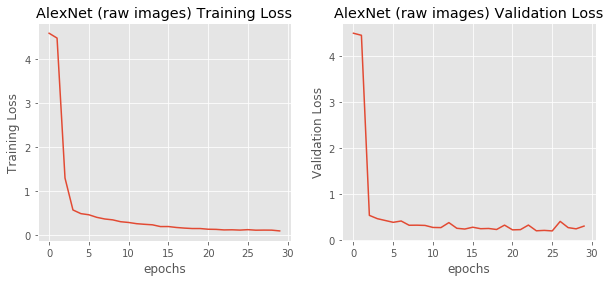

In [66]:
#Plot the results
plot_losses(alexnet_raw, 'AlexNet (raw images)')

We see validation and training loss decrease as the epochs increase, which is likely the result of using validation data in the training epochs.

## ResNet Style Convolutional Neural Network

In [15]:
# create resnet inspired NN
# trainable_lower_layers flag fixes weights for all but the top two layers of the network
def create_resnet(img_hw=100, l2_lambda=0.0001, trainable_lower_layers=True):
    input_holder = Input(shape=(img_hw,img_hw,3))
    # ResNet style cnn
    x = Conv2D(filters=32,
                    kernel_size=(3,3), 
                    input_shape = (img_hw,img_hw,3),
                    kernel_initializer='he_uniform',
                    kernel_regularizer=l2(l2_lambda),
                    padding='same', 
                    activation='relu', data_format="channels_last",
                    trainable=trainable_lower_layers)(input_holder) # more compact syntax
    x = MaxPooling2D(pool_size=(2, 2), data_format="channels_last",
                    trainable=trainable_lower_layers)(x)
    x = Conv2D(filters=32,
                    kernel_size=(3,3), 
                    kernel_initializer='he_uniform',
                    kernel_regularizer=l2(l2_lambda),
                    padding='same', 
                    activation='relu',
                    trainable=trainable_lower_layers)(x) # more compact syntax
    x_split = MaxPooling2D(pool_size=(2, 2), data_format="channels_last",
                    trainable=trainable_lower_layers)(x)
    x = Conv2D(filters=64,
                    kernel_size=(1,1), 
                    kernel_initializer='he_uniform',
                    kernel_regularizer=l2(l2_lambda),
                    padding='same', 
                    activation='relu',
                    trainable=trainable_lower_layers)(x_split) # more compact syntax
    x = Conv2D(filters=64,
                    kernel_size=(3,3), 
                    kernel_initializer='he_uniform',
                    kernel_regularizer=l2(l2_lambda),
                    padding='same', 
                    activation='relu',
                    trainable=trainable_lower_layers)(x) # more compact syntax
    x = Conv2D(filters=32,
                    kernel_size=(1,1), 
                    kernel_initializer='he_uniform',
                    kernel_regularizer=l2(l2_lambda),
                    padding='same', 
                    activation='relu',
                    trainable=trainable_lower_layers)(x) # more compact syntax
    x = Add()([x, x_split])
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size = (2,2), data_format = 'channels_last',
                    trainable=trainable_lower_layers)(x)
    x = Flatten()(x)
    x = Dropout(0.25)(x) 
    x = Dense(128, 
              activation='relu',
              kernel_initializer = 'he_uniform',
              kernel_regularizer = l2(l2_lambda))(x)
    x = Dropout(0.5)(x) 
    x = Dense(NUM_CLASSES, 
              activation='softmax',
              kernel_initializer = 'glorot_uniform',
              kernel_regularizer = l2(l2_lambda))(x)

    return Model(inputs = input_holder, outputs = x)

In [16]:
resnet_raw = create_resnet()
resnet_raw.summary()
resnet_raw.compile(loss='categorical_crossentropy', # 'categorical_crossentropy' 'mean_squared_error'
              optimizer='rmsprop', # 'adadelta' 'rmsprop'
              metrics=[recall])

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 100, 100, 3)  0                                            
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 100, 100, 32) 896         input_2[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_3 (MaxPooling2D)  (None, 50, 50, 32)   0           conv2d_7[0][0]                   
__________________________________________________________________________________________________
conv2d_8 (Conv2D)               (None, 50, 50, 32)   9248        max_pooling2d_3[0][0]            
__________________________________________________________________________________________________
max_poolin

In [17]:
resnet_raw.fit(X_train, y_train_ohe, 
            batch_size=128,
            epochs=50, 
            shuffle=True, verbose=1, 
            validation_data=(X_test,y_test_ohe),
            callbacks=[EarlyStopping(monitor='val_loss', patience=4)]) ## early stopping after val_loss decreases after 4

Train on 10319 samples, validate on 2580 samples
Epoch 1/50
10319/10319 [==============================] - 7s 644us/step - loss: 4.5925 - recall: 0.7179 - val_loss: 4.4884 - val_recall: 0.7240
Epoch 2/50
10319/10319 [==============================] - 6s 569us/step - loss: 4.4799 - recall: 0.7241 - val_loss: 4.4709 - val_recall: 0.7240
Epoch 3/50
10319/10319 [==============================] - 6s 568us/step - loss: 4.4592 - recall: 0.7241 - val_loss: 3.0949 - val_recall: 0.7240
Epoch 4/50
10319/10319 [==============================] - 6s 569us/step - loss: 0.7559 - recall: 0.7273 - val_loss: 1.1136 - val_recall: 0.3682
Epoch 5/50
10319/10319 [==============================] - 6s 579us/step - loss: 0.4976 - recall: 0.7656 - val_loss: 0.4445 - val_recall: 0.7872
Epoch 6/50
10319/10319 [==============================] - 6s 582us/step - loss: 0.4772 - recall: 0.7884 - val_loss: 0.4382 - val_recall: 0.7957
Epoch 7/50
10319/10319 [==============================] - 6s 573us/step - loss: 0.4933 

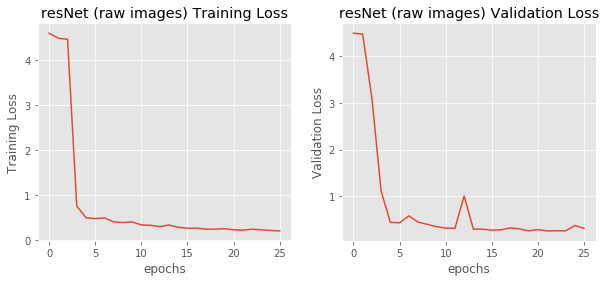

In [67]:
plot_losses(resnet_raw, 'resNet (raw images)')

We again see validation and training loss are stable and decreasing, likely due to our use of validation data in the training epochs.

## Comparing confusion matrixes of both CNN, without cross-validation or data generation

The matrices below indicate that the ResNet style network may be better at accurately classifying an image when a knife is present (recall).

We are also using unsound methods by exposing the validation data set during training, which is corrected later when using cross validation.

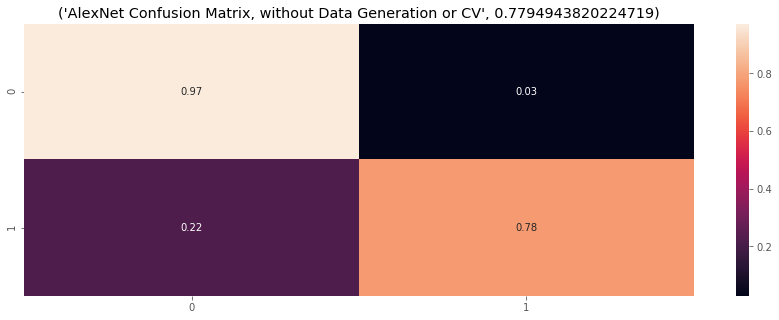

In [19]:
summarize_net(alexnet_raw, X_test, y_test_int, title_text = 'AlexNet Confusion Matrix, without Data Generation or CV')

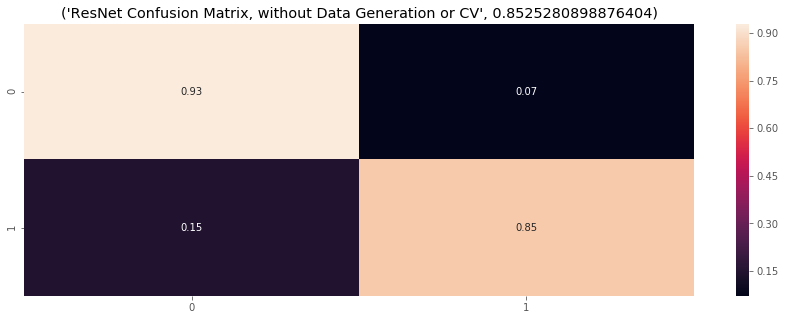

In [20]:
summarize_net(resnet_raw, X_test, y_test_int, title_text = 'ResNet Confusion Matrix, without Data Generation or CV')

We can also compare the performance using McNemar's test, or the "within-subjects chi-squared test".  This tests the null hypothesis that both models have the same performance, with a significance level of 0.05.

In [21]:
from mlxtend.evaluate import mcnemar_table, mcnemar
# use mcnemar's test to determine if observed difference between two models 
#    is statistically significant with 5% significance level
def mcnemar_test(model1, model2, X_test, y_test_int):
    # get probabilities
    y_hat_1 = model1.predict(X_test)
    y_hat_2 = model2.predict(X_test)
    # get most probable prediction
    y_hat_bin_1 = np.argmax(y_hat_1, 1)
    y_hat_bin_2 = np.argmax(y_hat_2, 1)

    tb = mcnemar_table(y_target=y_test_int, 
                   y_model1=y_hat_bin_1, 
                   y_model2=y_hat_bin_2)
    # use exact if small sample size
    if tb[0,1] + tb[1,0] < 25:
        exact_flag = True
    else:
        exact_flag = False

    _, p_val = mcnemar(tb, exact=exact_flag)

    print('p-value for observed difference with alpha=0.05:', round(p_val,5))
    
    return p_val

In [65]:
_ = mcnemar_test(alexnet_raw, resnet_raw, X_test, y_test_int)

p-value for observed difference with alpha=0.05: 0.10072


A low p-value would lead us to conclude that the two models perform differently with statistical confidence.  However, the p-value observered here is higher than the confidence value of 0.05, so we cannot conclude that there is a statistically significant difference between the two models.  

Therefore, we conclude that they both perform equally under these conditions.

## Data Generation

We perturb the original dataset in order to obtain a more robustly trained neural network.  It is intuitative to add horizontal flip to the perturbations, but we also add vertical flip given that officers may become prone or moving rapidly when on duty.  We did not have time to test these perturbations extensively.

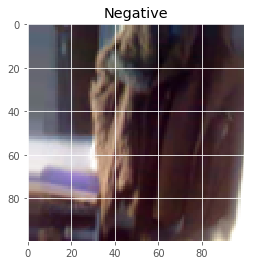

Wall time: 2.68 s


In [35]:
%%time
classes = ['Negative', 'Positive']


datagen = ImageDataGenerator(featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=5, # used, Int. Degree range for random rotations.
    width_shift_range=0.1, # used, Float (fraction of total width). Range for random horizontal shifts.
    height_shift_range=0.1, # used,  Float (fraction of total height). Range for random vertical shifts.
    shear_range=0., # Float. Shear Intensity (Shear angle in counter-clockwise direction as radians)
    zoom_range=0.,
    channel_shift_range=0.,
    fill_mode='nearest',
    cval=0.,
    horizontal_flip=True, # added horizontally flipped images
    vertical_flip=False, # added vertically flipped images
    rescale=None)

datagen.fit(X_train)
idx = 0
tmps = datagen.flow(X_train, y_train_ohe, batch_size=1)

for tmp in tmps:
    plt.imshow((tmp[0][0]).astype(np.uint8))
    #plt.imshow(tmp[0].squeeze(), cmap = 'bone')
    plt.title(classes[np.argmax(tmp[1])])
    plt.show()
    break

Here we create a model using the fit_generator to perturb the images, for both styles of neural networks.

In [36]:
alexnet = create_alexnet()
alexnet.compile(loss='categorical_crossentropy', # 'categorical_crossentropy' 'mean_squared_error'
              optimizer='rmsprop', # 'adadelta' 'rmsprop'
              metrics=[recall])
alexnet.fit_generator(datagen.flow(X_train, y_train_ohe, batch_size=128), 
        steps_per_epoch=int(len(X_train)/128), epochs=50, 
        shuffle=True, verbose=1, 
        validation_data=(X_test,y_test_ohe),
        callbacks=[EarlyStopping(monitor='val_loss', patience=4)])


Epoch 1/50
80/80 [==============================] - 19s 241ms/step - loss: 5.0704 - recall: 0.6909 - val_loss: 4.5316 - val_recall: 0.7240
Epoch 2/50
80/80 [==============================] - 18s 227ms/step - loss: 4.5221 - recall: 0.7236 - val_loss: 4.4910 - val_recall: 0.7240
Epoch 3/50
80/80 [==============================] - 18s 225ms/step - loss: 4.4574 - recall: 0.7247 - val_loss: 4.4426 - val_recall: 0.7240
Epoch 4/50
80/80 [==============================] - 18s 225ms/step - loss: 0.9423 - recall: 0.7177 - val_loss: 3.4837 - val_recall: 0.7240
Epoch 5/50
80/80 [==============================] - 18s 225ms/step - loss: 0.6172 - recall: 0.7226 - val_loss: 0.5319 - val_recall: 0.7240
Epoch 6/50
80/80 [==============================] - 18s 225ms/step - loss: 0.5505 - recall: 0.7242 - val_loss: 0.5412 - val_recall: 0.7240
Epoch 7/50
80/80 [==============================] - 18s 224ms/step - loss: 0.5154 - recall: 0.7233 - val_loss: 0.4823 - val_recall: 0.7388
Epoch 8/50
80/80 [=========

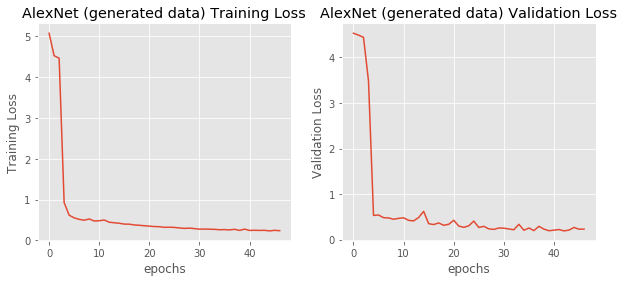

In [69]:
plot_losses(alexnet, 'AlexNet (generated data)')

In [38]:
resnet = create_resnet()
resnet.compile(loss='categorical_crossentropy', # 'categorical_crossentropy' 'mean_squared_error'
              optimizer='rmsprop', # 'adadelta' 'rmsprop'
              metrics=[recall])
resnet.fit_generator(datagen.flow(X_train, y_train_ohe, batch_size=128), 
            steps_per_epoch=int(len(X_train)/128), epochs=50, 
            shuffle=True, verbose=1, 
            validation_data=(X_test,y_test_ohe),
            callbacks=[EarlyStopping(monitor='val_loss', patience=4)]) ## early stopping after val_loss decreases after 4

Epoch 1/50
80/80 [==============================] - 19s 238ms/step - loss: 4.5006 - recall: 0.7239 - val_loss: 4.4964 - val_recall: 0.7240
Epoch 2/50
80/80 [==============================] - 18s 226ms/step - loss: 4.4839 - recall: 0.7243 - val_loss: 4.4774 - val_recall: 0.7240
Epoch 3/50
80/80 [==============================] - 18s 226ms/step - loss: 4.4689 - recall: 0.7238 - val_loss: 4.4568 - val_recall: 0.7240
Epoch 4/50
80/80 [==============================] - 18s 226ms/step - loss: 1.2498 - recall: 0.7105 - val_loss: 0.5381 - val_recall: 0.7236
Epoch 5/50
80/80 [==============================] - 18s 226ms/step - loss: 0.6009 - recall: 0.7147 - val_loss: 0.5067 - val_recall: 0.7240
Epoch 6/50
80/80 [==============================] - 18s 225ms/step - loss: 0.5865 - recall: 0.7210 - val_loss: 0.4848 - val_recall: 0.7240
Epoch 7/50
80/80 [==============================] - 18s 226ms/step - loss: 0.5557 - recall: 0.7255 - val_loss: 0.4829 - val_recall: 0.7283
Epoch 8/50
80/80 [=========

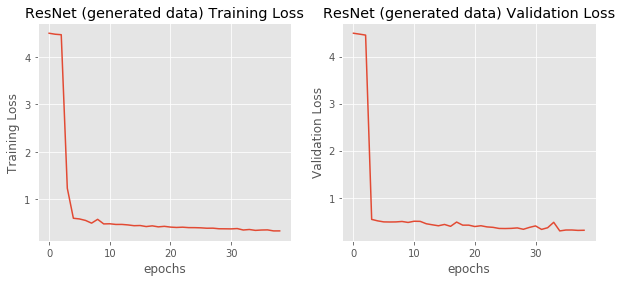

In [70]:
plot_losses(resnet, 'ResNet (generated data)')

The validation plots for both models are again well behaved when using data generation to perturb the input data set.

## Comparing confusion matrixes of both CNN, with data generation

The following confusion matrices summarize the performance of the models using the data generation pipeline.

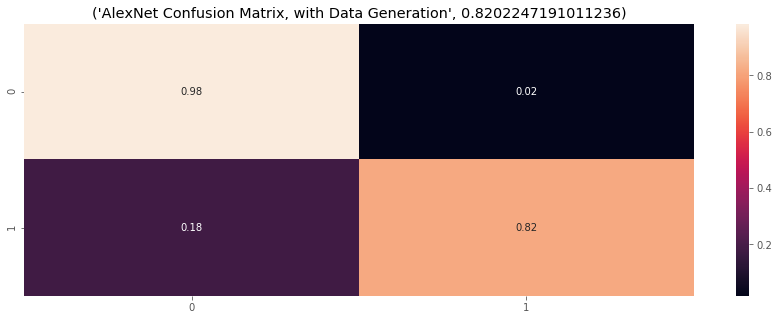

In [40]:
summarize_net(alexnet, X_test, y_test_int, title_text = 'AlexNet Confusion Matrix, with Data Generation')

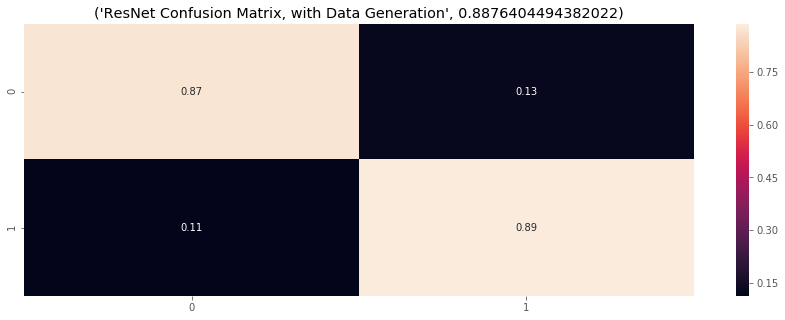

In [41]:
summarize_net(resnet, X_test, y_test_int, title_text = 'ResNet Confusion Matrix, with Data Generation')

In [45]:
_ = mcnemar_test(alexnet, resnet, X_test, y_test_int)

p-value for observed difference with alpha=0.05: 0.0


We find a p-val for the McNemar test ofthe AlexNet and ResNet models when data generation of 0.0, which indicates with high confidence that the models are not the same and that the ResNet performs better.

In [47]:
_ = mcnemar_test(alexnet_raw, alexnet, X_test, y_test_int)
_ = mcnemar_test(resnet_raw, resnet, X_test, y_test_int)

p-value for observed difference with alpha=0.05: 0.00208
p-value for observed difference with alpha=0.05: 2e-05


The above p-values indicate that the observed improvment using either model combined with the data generation is statistically significant.

## Cross Validation

Up to this point we have been using unsound methods by exposing the validation data set when making decisions about training the models.  We can avoid this by using cross valition.  We choose to use 5-fold cross validation to train the networks.  It is more accepted to use 10 folds, but we choose 5 folds to reduce the computational load for this lab. 

By dividing the data into folds and training on all but one fold and comparing the model performance to the 'left out' fold, we develop a more robust estimate of the error while training without resorting to snooping on the test data set.  Each time we leave a different fold out, we train the model but prevent it from learning the data contained in the left out fold.  Presuming the data we have is representative of what will be seen in production, cross validation offers the chance to simulate having multiple draws of data while eliminating data snooping on the data reserved for validation.  

In the following example, we train a model without using cross validation or exposing the validation set.

In [101]:
training_error_bad = resnet_cv = create_resnet()
training_error_bad.compile(loss='categorical_crossentropy', # 'categorical_crossentropy' 'mean_squared_error'
              optimizer='rmsprop', # 'adadelta' 'rmsprop'
              metrics=[recall])
training_error_bad.fit(X_train, y_train_ohe, 
        batch_size=128, 
        epochs=50, 
        shuffle=True, verbose=1, 
        callbacks=[EarlyStopping(monitor='loss', patience=4)])

Epoch 1/50
10319/10319 [==============================] - 7s 636us/step - loss: 11.6907 - recall: 0.2764
Epoch 2/50
10319/10319 [==============================] - 5s 511us/step - loss: 4.6179 - recall: 0.7139
Epoch 3/50
10319/10319 [==============================] - 5s 509us/step - loss: 1.9351 - recall: 0.7153
Epoch 4/50
10319/10319 [==============================] - 5s 509us/step - loss: 0.5528 - recall: 0.7403
Epoch 5/50
10319/10319 [==============================] - 5s 511us/step - loss: 0.4620 - recall: 0.7707
Epoch 6/50
10319/10319 [==============================] - 5s 510us/step - loss: 0.4782 - recall: 0.7881
Epoch 7/50
10319/10319 [==============================] - 5s 512us/step - loss: 0.4255 - recall: 0.8052
Epoch 8/50
10319/10319 [==============================] - 5s 517us/step - loss: 0.4212 - recall: 0.8195
Epoch 9/50
10319/10319 [==============================] - 5s 509us/step - loss: 0.3921 - recall: 0.8260
Epoch 10/50
10319/10319 [==============================] - 5s 5

Text(0.5, 0, 'epochs')

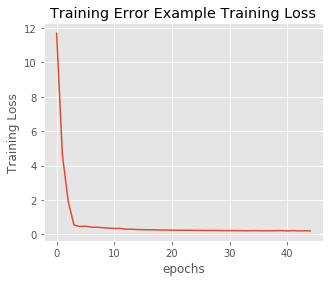

In [102]:
plt.figure(figsize=(5,4))
plt.plot(training_error_bad.history.history['loss'])
plt.title('Training Error Example' + ' Training Loss')
plt.ylabel('Training Loss')
plt.xlabel('epochs')

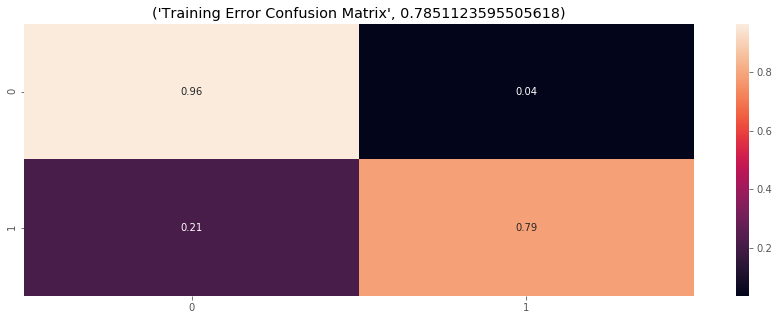

In [103]:
summarize_net(training_error_bad, X_test, y_test_int, title_text = 'Training Error Confusion Matrix')

The above example illustrates that training error is a poor loss function.  Although our recall is up to 94% on the training set, we have only 79% recall on the validation data.  The traininer error network has been optimized to effectively predict the training data, but is not as successful when predicting using data it has not seen before.

Although cross-validation is powerful and can be useful, it can be computationally expensive and is not always used in industry, particularly when large amounts of data is available.

We have chosen to use stratified sampling for the folds, due to the mildly imbalanced nature of our dataset.

In [93]:
from sklearn.model_selection import StratifiedKFold
import sklearn.metrics as mt

# helper for model training with cross validation
def train_model_cv(this_model, X_train, y_train_int, y_train_ohe):
    # set shuffler settings 
    shuffler = StratifiedKFold(n_splits=5, shuffle = True)

    i = 0
    manual_history = {}
    manual_history['loss'] = []
    manual_history['val_loss'] = []
    
    # generates a set of train and test indices based on the number of folds (i.e. splits) selected
    for train_index, test_index in shuffler.split(X_train, y_train_int): 
        i += 1
        print('holding fold {} out'.format(i))
        this_model.fit_generator(datagen.flow(X_train[train_index], y_train_ohe[train_index], batch_size=128), 
                    steps_per_epoch=int(len(X_train[train_index])/128), epochs=50, 
                    shuffle=True, verbose=1, 
                    validation_data=(X_train[test_index], y_train_ohe[test_index]),
                    callbacks=[EarlyStopping(monitor='val_loss', patience=4)]) ## early stopping after val_loss decreases after 4
        manual_history['loss'] = manual_history['loss'] + this_model.history.history['loss']
        manual_history['val_loss'] = manual_history['val_loss'] + this_model.history.history['val_loss']
    
    return manual_history


We train a new AlexNet-inspired model using cross validation.

holding fold 1 out
Epoch 1/50
64/64 [==============================] - 16s 252ms/step - loss: 4.5864 - recall: 0.7208 - val_loss: 4.5293 - val_recall: 0.7240
Epoch 2/50
64/64 [==============================] - 14s 226ms/step - loss: 4.5164 - recall: 0.7240 - val_loss: 4.4990 - val_recall: 0.7240
Epoch 3/50
64/64 [==============================] - 15s 227ms/step - loss: 4.4699 - recall: 0.7245 - val_loss: 4.4531 - val_recall: 0.7240
Epoch 4/50
64/64 [==============================] - 15s 229ms/step - loss: 1.8076 - recall: 0.7246 - val_loss: 0.5919 - val_recall: 0.7240
Epoch 5/50
64/64 [==============================] - 15s 228ms/step - loss: 0.5782 - recall: 0.7210 - val_loss: 0.5408 - val_recall: 0.7240
Epoch 6/50
64/64 [==============================] - 15s 228ms/step - loss: 0.5519 - recall: 0.7250 - val_loss: 0.4837 - val_recall: 0.7240
Epoch 7/50
64/64 [==============================] - 15s 228ms/step - loss: 0.5308 - recall: 0.7252 - val_loss: 0.7204 - val_recall: 0.7206
Epoch 8/

64/64 [==============================] - 16s 245ms/step - loss: 0.2228 - recall: 0.9323 - val_loss: 0.1682 - val_recall: 0.9520
Epoch 2/50
64/64 [==============================] - 15s 230ms/step - loss: 0.2232 - recall: 0.9310 - val_loss: 0.2539 - val_recall: 0.9132
Epoch 3/50
64/64 [==============================] - 15s 229ms/step - loss: 0.2159 - recall: 0.9270 - val_loss: 0.2088 - val_recall: 0.9239
Epoch 4/50
64/64 [==============================] - 15s 229ms/step - loss: 0.2190 - recall: 0.9345 - val_loss: 0.1711 - val_recall: 0.9447
Epoch 5/50
64/64 [==============================] - 15s 229ms/step - loss: 0.2310 - recall: 0.9290 - val_loss: 0.1714 - val_recall: 0.9510
holding fold 5 out
Epoch 1/50
64/64 [==============================] - 16s 254ms/step - loss: 0.2148 - recall: 0.9375 - val_loss: 0.1433 - val_recall: 0.9632
Epoch 2/50
64/64 [==============================] - 15s 229ms/step - loss: 0.2199 - recall: 0.9332 - val_loss: 0.1490 - val_recall: 0.9641
Epoch 3/50
64/64 [=

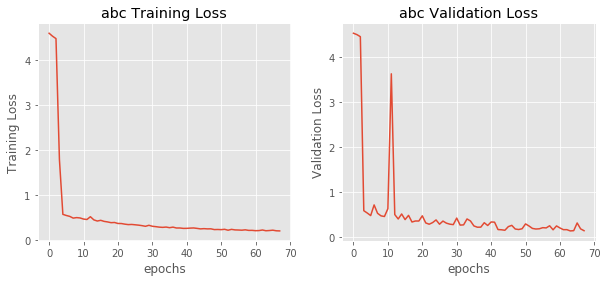

In [96]:
alexnet_cv = create_alexnet()
alexnet_cv.compile(loss='categorical_crossentropy', # 'categorical_crossentropy' 'mean_squared_error'
              optimizer='rmsprop', # 'adadelta' 'rmsprop'
              metrics=[recall])
manual_history = train_model_cv(alexnet_cv, X_train, y_train_int, y_train_ohe)
plot_losses_manual(manual_history, 'abc')

Note that we do not reset the weights between fitting with different folds, so it is not suprising to see later folds converge much more quickly.

We also train a new ResNet-inspired model using cross validation.

holding fold 1 out
Epoch 1/50
64/64 [==============================] - 16s 244ms/step - loss: 4.5885 - recall: 0.7183 - val_loss: 4.4908 - val_recall: 0.7240
Epoch 2/50
64/64 [==============================] - 15s 230ms/step - loss: 4.4598 - recall: 0.7256 - val_loss: 4.4799 - val_recall: 0.7240
Epoch 3/50
64/64 [==============================] - 15s 238ms/step - loss: 4.4691 - recall: 0.7242 - val_loss: 4.4647 - val_recall: 0.7240
Epoch 4/50
64/64 [==============================] - 15s 228ms/step - loss: 3.5952 - recall: 0.7156 - val_loss: 0.5565 - val_recall: 0.7215
Epoch 5/50
64/64 [==============================] - 15s 229ms/step - loss: 0.5886 - recall: 0.7109 - val_loss: 0.5386 - val_recall: 0.7245
Epoch 6/50
64/64 [==============================] - 15s 228ms/step - loss: 0.5754 - recall: 0.7126 - val_loss: 0.5709 - val_recall: 0.7245
Epoch 7/50
64/64 [==============================] - 15s 228ms/step - loss: 0.5443 - recall: 0.7226 - val_loss: 0.4685 - val_recall: 0.7409
Epoch 8/

64/64 [==============================] - 15s 228ms/step - loss: 0.3543 - recall: 0.8540 - val_loss: 0.3115 - val_recall: 0.8837
Epoch 12/50
64/64 [==============================] - 15s 229ms/step - loss: 0.3485 - recall: 0.8525 - val_loss: 0.2860 - val_recall: 0.8890
Epoch 13/50
64/64 [==============================] - 15s 229ms/step - loss: 0.3575 - recall: 0.8530 - val_loss: 0.3289 - val_recall: 0.8720
Epoch 14/50
64/64 [==============================] - 15s 228ms/step - loss: 0.3484 - recall: 0.8594 - val_loss: 0.3332 - val_recall: 0.8764
Epoch 15/50
64/64 [==============================] - 15s 228ms/step - loss: 0.3521 - recall: 0.8549 - val_loss: 0.2865 - val_recall: 0.8778
Epoch 16/50
64/64 [==============================] - 15s 229ms/step - loss: 0.3508 - recall: 0.8558 - val_loss: 0.3189 - val_recall: 0.8769
holding fold 4 out
Epoch 1/50
64/64 [==============================] - 16s 244ms/step - loss: 0.3463 - recall: 0.8625 - val_loss: 0.2832 - val_recall: 0.8871
Epoch 2/50
64/

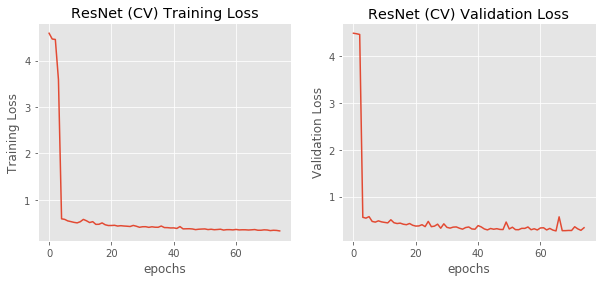

In [111]:
resnet_cv = create_resnet()
resnet_cv.compile(loss='categorical_crossentropy', # 'categorical_crossentropy' 'mean_squared_error'
              optimizer='rmsprop', # 'adadelta' 'rmsprop'
              metrics=[recall])
manual_history = train_model_cv(resnet_cv, X_train, y_train_int, y_train_ohe)
plot_losses_manual(manual_history, 'ResNet (CV)')

### Comparing AlexNet and ResNet, with cross-validation and data generation

The matrices below indicate that the AlexNet style network is better at accurately classifying an image when a knife is present.

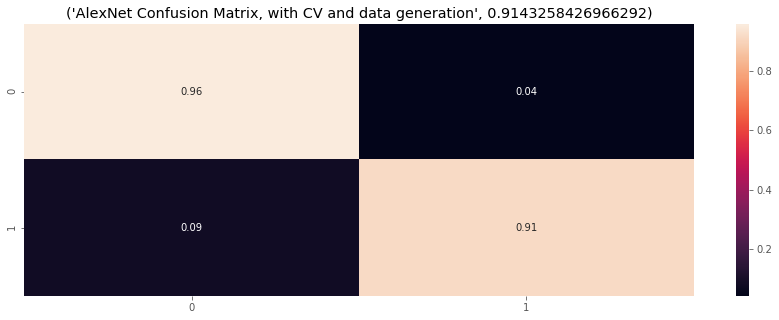

In [112]:
summarize_net(alexnet_cv, X_test, y_test_int, title_text = 'AlexNet Confusion Matrix, with CV and data generation')

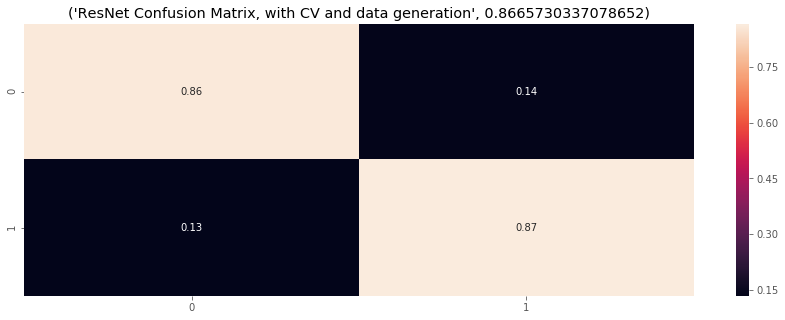

In [113]:
summarize_net(resnet_cv, X_test, y_test_int, title_text = 'ResNet Confusion Matrix, with CV and data generation')

In [118]:
_ = mcnemar_test(alexnet_cv, resnet_cv, X_test, y_test_int)

p-value for observed difference with alpha=0.05: 0.0


Again we compare the models using the McNemar test, and find that AlexNet has superior performance with high confidence.  

In [119]:
_ = mcnemar_test(alexnet, alexnet_cv, X_test, y_test_int)

p-value for observed difference with alpha=0.05: 0.19043


However, we do not find a statistically significant difference between the performance of the AlexNet-style network when using the validation data or cross-validation.  Since the cross-validation method is statistically sound and exposing the test data is not, we will use cross validation.

In [120]:
_ = mcnemar_test(resnet, resnet_cv, X_test, y_test_int)

p-value for observed difference with alpha=0.05: 0.07049


Neither do we observe a statistically significant difference between usiing the validation data and using cross-validation.

## Comparison the a Mutli-Layer Perceptron

Below, we build a mullti-layer perceptron and compare with our AlexNet-type CNN.

In [141]:
from sklearn import metrics as mt
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

In [142]:
from keras.models import Sequential

l2_lambda = 0.0001

mlp = Sequential()

mlp.add(Flatten(input_shape=(img_hw, img_hw, 3))) # flatten input images for mlp
mlp.add(Dense(units=128, 
              activation='relu',
              kernel_initializer = 'he_uniform',
              kernel_regularizer = l2(l2_lambda)))
mlp.add(Dropout(0.1))
mlp.add(Dense(units=64, activation='relu',
              kernel_initializer = 'he_uniform',
              kernel_regularizer = l2(l2_lambda)))
mlp.add(Dense(units=32, activation='relu',
              kernel_initializer = 'he_uniform',
              kernel_regularizer = l2(l2_lambda)))
mlp.add(Dropout(0.25))
mlp.add(Dense(units=32, activation='relu',
              kernel_initializer = 'he_uniform',
              kernel_regularizer = l2(l2_lambda)))
mlp.add(Dropout(0.5))
mlp.add(Dense(NUM_CLASSES, activation='softmax',
              kernel_initializer='glorot_uniform',
              kernel_regularizer=l2(l2_lambda)))

mlp.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=[recall])
mlp.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_24 (Flatten)         (None, 30000)             0         
_________________________________________________________________
dense_55 (Dense)             (None, 128)               3840128   
_________________________________________________________________
dropout_49 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_56 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_57 (Dense)             (None, 32)                2080      
_________________________________________________________________
dropout_50 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_58 (Dense)             (None, 32)                1056      
__________

In [143]:
manual_history = train_model_cv(mlp, X_train, y_train_int, y_train_ohe)

holding fold 1 out
Epoch 1/50
64/64 [==============================] - 16s 246ms/step - loss: 9.3345 - recall: 0.4229 - val_loss: 11.6970 - val_recall: 0.2765
Epoch 2/50
64/64 [==============================] - 15s 233ms/step - loss: 8.7475 - recall: 0.4595 - val_loss: 11.7008 - val_recall: 0.2760
Epoch 3/50
64/64 [==============================] - 15s 231ms/step - loss: 8.1000 - recall: 0.4990 - val_loss: 4.4719 - val_recall: 0.7240
Epoch 4/50
64/64 [==============================] - 15s 232ms/step - loss: 6.5911 - recall: 0.5918 - val_loss: 4.4686 - val_recall: 0.7240
Epoch 5/50
64/64 [==============================] - 15s 234ms/step - loss: 6.0813 - recall: 0.6236 - val_loss: 4.4657 - val_recall: 0.7240
Epoch 6/50
64/64 [==============================] - 15s 232ms/step - loss: 6.1465 - recall: 0.6196 - val_loss: 4.4644 - val_recall: 0.7240
Epoch 7/50
64/64 [==============================] - 15s 230ms/step - loss: 6.3969 - recall: 0.6039 - val_loss: 4.4644 - val_recall: 0.7240
Epoch 

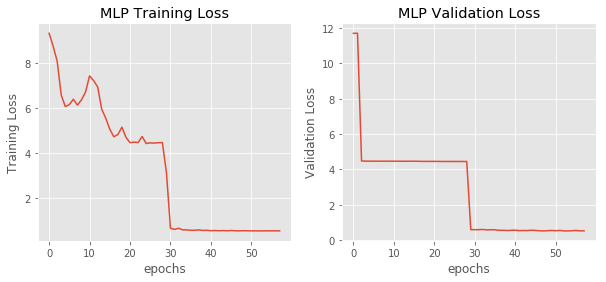

In [156]:
plot_losses_manual(manual_history, 'MLP')

The MLP model performs very poorly on our dataset, as it is not able to adapt to predict anything other than 'positive'. The cross-validation error is locked at 0.72, which is the recall if predict positive for all data.  Other networks often start with this setting, but adjust to become more accurate.  The multilayer perceptron appears to be unable to do so.

In [145]:
1- np.sum(y_test_int)/len(X_test)

0.724031007751938

We can examine the performance using McNemar's test.

In [180]:
_ = mcnemar_test(mlp, alexnet_cv, X_test, y_test_int)

p-value for observed difference with alpha=0.05: 0.0


# Exceptional Work

Since the available networks do not appear likely to predict the presence of a knife, we instead attempt to use the AlexNet convolutional nueral network developed here as the source network for transfer learning on a completely different set of images caputured from a video game, Fallout 4.

In [157]:
y_hat = alexnet_cv.predict(X_test) # prediction
print(y_hat[0], y_test[0])

[0.9914357  0.00856433] negative


We save the weights from previous trained network to load into new network.

In [158]:
alexnet_cv.save_weights('alexnet_weights')

We then rebuild AlexNet, using trainable=False on all but last two dense layers


In [159]:
# rebuild AlexNet, using trainable=False on all but final dense layers
alexnet2 = create_alexnet(trainable_lower_layers=False)
alexnet2.compile(loss='categorical_crossentropy', # 'categorical_crossentropy' 'mean_squared_error'
              optimizer='rmsprop', # 'adadelta' 'rmsprop'
              metrics=[recall])
alexnet2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_22 (InputLayer)        (None, 100, 100, 3)       0         
_________________________________________________________________
conv2d_120 (Conv2D)          (None, 100, 100, 32)      896       
_________________________________________________________________
conv2d_121 (Conv2D)          (None, 100, 100, 32)      9248      
_________________________________________________________________
max_pooling2d_50 (MaxPooling (None, 33, 33, 32)        0         
_________________________________________________________________
conv2d_122 (Conv2D)          (None, 33, 33, 64)        18496     
_________________________________________________________________
conv2d_123 (Conv2D)          (None, 33, 33, 64)        36928     
_________________________________________________________________
max_pooling2d_51 (MaxPooling (None, 11, 11, 64)        0         
__________

We have now created a 2nd version of the alexnet convolutional neural network that uses the fixed pre-trained weights from the first 12 layers and has trainable weights in the last two layers.  This is likely not particularly helpful, since there are 2 million trainable weights and 300k untrainable weights, but we proceed with the expectation that this method could save training time when used with a larger neural network.

In [161]:
alexnet2.load_weights('alexnet_weights')
is_same = True
for j in range(len(alexnet_cv.layers)):
    for i in range(len(alexnet_cv.layers[j].get_weights())):
        if np.array_equiv(alexnet_cv.layers[j].get_weights()[i], alexnet2.layers[j].get_weights()[i]) == False:
            is_same = False
print('two versions have same weights?', is_same)
y_hat = alexnet2.predict(X_test) # prediction
print(y_hat[0], y_test[0])

two versions have same weights? True
[0.9914357  0.00856433] negative


We load the same weights from the previously trained version.  Note that the probabilities obtained using predict() are the same using the 1st and 2nd versions of our alexnet-style convolutional neural network.

To obtain more data we gathered screenshots from a PC computer game (Fallout 4), with a 1st or close 3rd person perspective.  Used approximately 15 minutes of captured footage of the avatar aiming a pistol, holding a knife, or holding nothing.  From this footage generated 7-8,000 unique frames for each category, to be used in testing

In [162]:
from scipy.misc import imresize

# read frames from video or saved npy files
none_files = ['n1.mkv', 'n2.mkv', 'n3.mkv', 'n4.mkv', 'n5.mkv']
gun_files = ['g1.mkv', 'g2.mkv', 'g3.mkv', 'g4.mkv']
knife_files = ['k1.mkv', 'k2.mkv', 'k3.mkv', 'k4.mkv']

none_frames = []
gun_frames = []
knife_frames = []

def read_video_files(file_list, frame_list, is_knife=False, img_hw=100):
    for f in file_list:
        cap = cv2.VideoCapture(f)
        while(cap.isOpened()):
            ret, frame = cap.read()
            if ret == False:
                cap.release()
            else:
                # recorded 1920x1080 but game was in 1366x768, want 768x768
                # crop to the right if knife
                if is_knife == True:
                    cropped = frame[0:768,598:1366,:]
                # crop from the left for none and gone
                else:
                    cropped = frame[0:768,0:768,:]
#                 rescaled = cv2.resize(cropped, (img_hw,img_hw))
                #slightly better results using the antialiasing instead of cv2.resize()
                rescaled = imresize(cropped, size=(100,100,3), interp='nearest')
                frame_list.append(rescaled)

refresh = False
# read
if refresh == True:
    read_video_files(none_files, none_frames)
    read_video_files(gun_files, gun_frames)
    read_video_files(knife_files, knife_frames, is_knife=True)
    
    
    np.save('none_frames.npz', none_frames)
    np.save('gun_frames.npz', gun_frames)
    np.save('knife_frames.npz', knife_frames)
    
else:
    none_frames = list(np.load('none_frames.npy'))
    gun_frames = list(np.load('gun_frames.npy'))
    knife_frames = list(np.load('knife_frames.npy'))

print(len(none_frames), len(gun_frames), len(knife_frames))

7984 8517 7004


In [163]:
# create new training sets
y_knife = ['negative']*len(none_frames) + ['positive']*len(knife_frames)
y_knife = np.asarray(y_knife)
X_knife = none_frames + knife_frames
X_knife = np.asarray(X_knife)
Xk_train, Xk_test, yk_train, yk_test = train_test_split(X_knife, y_knife,
                                        shuffle = True, stratify = y_knife, test_size = 0.2, random_state = 42)


y_gun = ['negative']*len(none_frames) + ['positive']*len(gun_frames)
y_gun = np.asarray(y_gun)
X_gun = none_frames + gun_frames
X_gun = np.asarray(X_gun)
Xg_train, Xg_test, yg_train, yg_test = train_test_split(X_gun, y_gun,
                                        shuffle = True, stratify = y_gun, test_size = 0.2, random_state = 42)


# encode y
le = LabelEncoder()

yk_train_int = le.fit_transform(yk_train)
yk_test_int = le.fit_transform(yk_test)

# use keras one hot enconder
yk_train_ohe = keras.utils.to_categorical(yk_train_int, NUM_CLASSES)
yk_test_ohe = keras.utils.to_categorical(yk_test_int, NUM_CLASSES)

yg_train_int = le.fit_transform(yg_train)
yg_test_int = le.fit_transform(yg_test)

# use keras one hot enconder
yg_train_ohe = keras.utils.to_categorical(yg_train_int, NUM_CLASSES)
yg_test_ohe = keras.utils.to_categorical(yg_test_int, NUM_CLASSES)

knife data


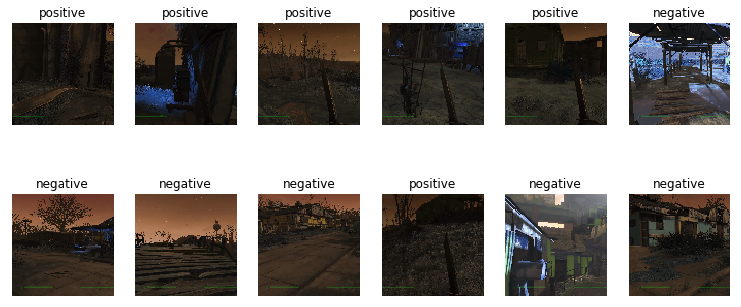

In [164]:
# view sample
img_hw = 100
print('knife data')
plot_gallery(Xk_train, yk_train, 100, 100, 2, 6)

gun data


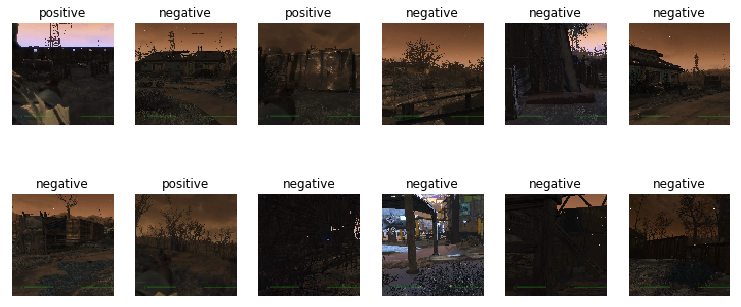

In [165]:
# view sample
print('gun data')
plot_gallery(Xg_train, yg_train, 100, 100, 2, 6)

Old model is not predictive on new dataset.

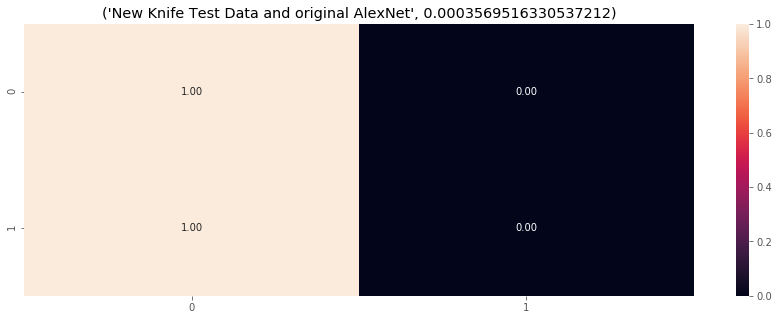

In [166]:
summarize_net(alexnet_cv, Xk_train, yk_train_int, title_text='New Knife Test Data and original AlexNet')

Retrain top two layers

In [167]:
manual_history = train_model_cv(alexnet2, Xk_train, yk_train_int, yk_train_ohe)

holding fold 1 out
Epoch 1/50
74/74 [==============================] - 19s 252ms/step - loss: 0.6964 - recall: 0.6288 - val_loss: 0.6486 - val_recall: 0.6528
Epoch 2/50
74/74 [==============================] - 17s 226ms/step - loss: 0.6192 - recall: 0.7059 - val_loss: 0.6077 - val_recall: 0.6899
Epoch 3/50
74/74 [==============================] - 17s 230ms/step - loss: 0.5919 - recall: 0.7338 - val_loss: 0.6189 - val_recall: 0.7124
Epoch 4/50
74/74 [==============================] - 17s 232ms/step - loss: 0.5758 - recall: 0.7442 - val_loss: 0.5650 - val_recall: 0.7495
Epoch 5/50
74/74 [==============================] - 17s 232ms/step - loss: 0.5609 - recall: 0.7545 - val_loss: 0.5820 - val_recall: 0.7403
Epoch 6/50
74/74 [==============================] - 17s 233ms/step - loss: 0.5552 - recall: 0.7561 - val_loss: 0.5906 - val_recall: 0.7274
Epoch 7/50
74/74 [==============================] - 17s 232ms/step - loss: 0.5542 - recall: 0.7611 - val_loss: 0.5662 - val_recall: 0.7499
Epoch 8/

74/74 [==============================] - 17s 231ms/step - loss: 0.4541 - recall: 0.8305 - val_loss: 0.4135 - val_recall: 0.8523
Epoch 5/50
74/74 [==============================] - 17s 232ms/step - loss: 0.4526 - recall: 0.8293 - val_loss: 0.4216 - val_recall: 0.8527
Epoch 6/50
74/74 [==============================] - 17s 231ms/step - loss: 0.4588 - recall: 0.8243 - val_loss: 0.4409 - val_recall: 0.8465
Epoch 7/50
74/74 [==============================] - 17s 230ms/step - loss: 0.4618 - recall: 0.8297 - val_loss: 0.4355 - val_recall: 0.8465
Epoch 8/50
74/74 [==============================] - 17s 230ms/step - loss: 0.4617 - recall: 0.8253 - val_loss: 0.4158 - val_recall: 0.8598


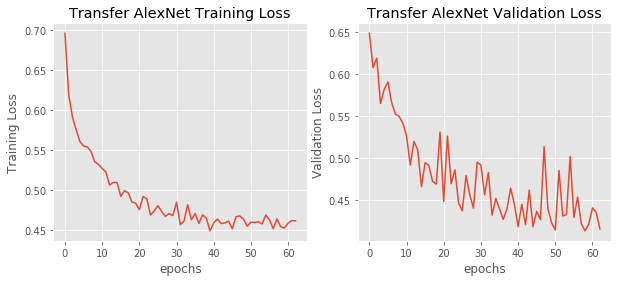

In [168]:
plot_losses_manual(manual_history, 'Transfer AlexNet')

Note that the weights for the early layers have not changed with the retraining of the 2nd alexnet, but the top layers (and predictions) have.

In [172]:
is_same = True
for j in range(len(alexnet_cv.layers) - 3):
    for i in range(len(alexnet_cv.layers[j].get_weights())):
        if np.array_equiv(alexnet_cv.layers[j].get_weights()[i], alexnet2.layers[j].get_weights()[i]) == False:
            is_same = False
print('two versions have same weights in early layers?', is_same)

two versions have same weights in early layers? True


Below, we epeat the predictions using the new weights for the dense layers.  Performance is better than random but not good, especially since we expect that this computer generated data is easier to classify than real-world data.

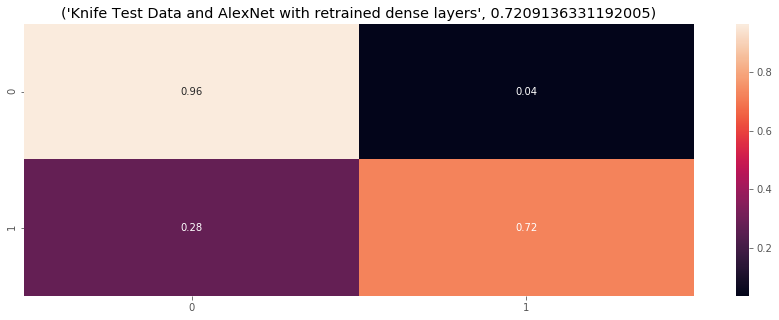

In [173]:
summarize_net(alexnet2, Xk_test, yk_test_int, title_text='Knife Test Data and AlexNet with retrained dense layers')

This network does not appear to identify when the player avatar is holding something, given the poor performance on the 'gun' dataset.

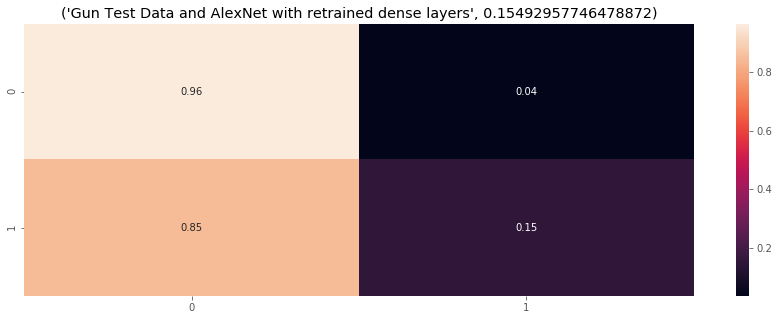

In [174]:
summarize_net(alexnet2, Xg_test, yg_test_int, title_text='Gun Test Data and AlexNet with retrained dense layers')

In our case we can retrain all the parameters in the model to obtain a better result, but that could potentially be cost prohibitive.

Here, we train a new alexnet model on the 'gun' computer generated data set.

In [175]:
alexnet3 = create_alexnet()
alexnet3.compile(loss='categorical_crossentropy', # 'categorical_crossentropy' 'mean_squared_error'
              optimizer='rmsprop', # 'adadelta' 'rmsprop'
              metrics=[recall])
alexnet3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_23 (InputLayer)        (None, 100, 100, 3)       0         
_________________________________________________________________
conv2d_126 (Conv2D)          (None, 100, 100, 32)      896       
_________________________________________________________________
conv2d_127 (Conv2D)          (None, 100, 100, 32)      9248      
_________________________________________________________________
max_pooling2d_52 (MaxPooling (None, 33, 33, 32)        0         
_________________________________________________________________
conv2d_128 (Conv2D)          (None, 33, 33, 64)        18496     
_________________________________________________________________
conv2d_129 (Conv2D)          (None, 33, 33, 64)        36928     
_________________________________________________________________
max_pooling2d_53 (MaxPooling (None, 11, 11, 64)        0         
__________

holding fold 1 out
Epoch 1/50
74/74 [==============================] - 19s 251ms/step - loss: 7.6234 - recall: 0.5329 - val_loss: 7.6189 - val_recall: 0.5327
Epoch 2/50
74/74 [==============================] - 17s 231ms/step - loss: 7.5834 - recall: 0.5338 - val_loss: 7.5732 - val_recall: 0.5327
Epoch 3/50
74/74 [==============================] - 17s 235ms/step - loss: 5.2864 - recall: 0.5335 - val_loss: 0.6962 - val_recall: 0.5344
Epoch 4/50
74/74 [==============================] - 17s 233ms/step - loss: 0.7211 - recall: 0.5384 - val_loss: 0.6845 - val_recall: 0.5327
Epoch 5/50
74/74 [==============================] - 17s 234ms/step - loss: 0.6950 - recall: 0.5644 - val_loss: 0.7289 - val_recall: 0.5573
Epoch 6/50
74/74 [==============================] - 17s 234ms/step - loss: 0.6628 - recall: 0.6298 - val_loss: 0.6118 - val_recall: 0.6474
Epoch 7/50
74/74 [==============================] - 17s 235ms/step - loss: 0.6049 - recall: 0.6748 - val_loss: 0.6251 - val_recall: 0.6344
Epoch 8/

74/74 [==============================] - 17s 234ms/step - loss: 0.0890 - recall: 0.9759 - val_loss: 0.1021 - val_recall: 0.9758


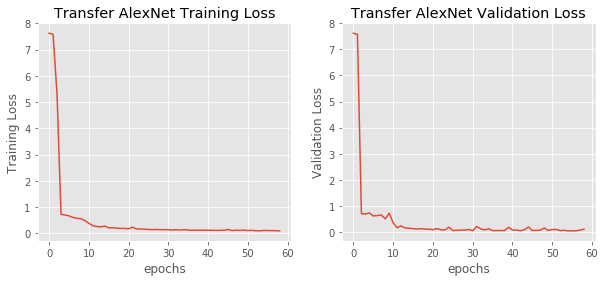

In [177]:
manual_history = train_model_cv(alexnet3, Xk_train, yk_train_int, yk_train_ohe)
plot_losses_manual(manual_history, 'Transfer AlexNet')

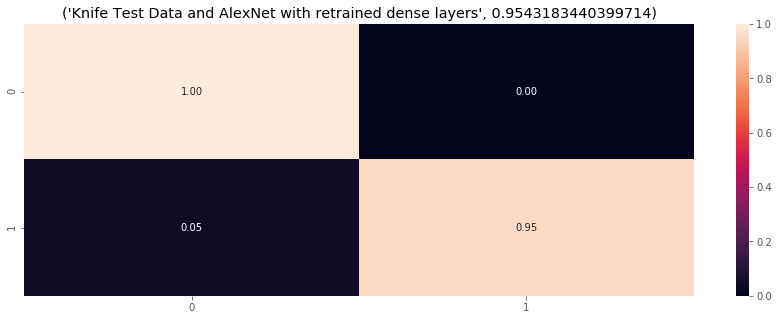

In [178]:
summarize_net(alexnet3, Xk_test, yk_test_int, title_text='Knife Test Data and AlexNet with retrained dense layers')

Here we obtain much better results by retraining the entire network, which is not impractical given the underlying network architecture we use.  However, if the underlying architecture was expensive to retrain we could use previous method of training only the topmost layers and leaving the weights on the lower levels fixed.

We still have questions about the efficacy of using this computer generated data to train a network intended to analyze real world data.

## Hyperparameter Tuning
We tried various settings to obtain better results when perturbing the images, and various versions of the ResNet and AlexNet convolutional neural networks, but did not have time to perform in depth hyperparameter tuning.  Time permitting, we would test multiple variations of the networks, particularly dropout rates and the l2 regularization parameter, as well as the perturbation methods.

There appears to be signifiant variability in performance of the training of the models as we have defined them, and we expect that tuning parameters would be difficult with a data set of this size.  It is possible that the variability would be improved if we had a larger dataset.  If we had more time, it would be interesting to extend the training time and run many different training sessions and compare the variability of the performance of the trainined networks on the testing data.  We suspect that this variability is large.

In [23]:
import smtplib
import yaml

# I really don't recommend doing this unless you have a dummy email account
# this requires storing your email password in yaml file
# you must enable "allow less secure apps" in your google settings in order to use this
def send_text_gmail(email_to, subject='Computation Finished', additional_text='', yaml_file='usr.yaml'):
    
    with open(yaml_file, 'r') as stream:
        user_settings = yaml.safe_load(stream)
    
    server = smtplib.SMTP('smtp.gmail.com', 587)
    server.ehlo()
    server.starttls()
    # REALLY don't recommend doing this unless you have a dummy email account
    # this requires storing your email password in yaml file (clear text)
    server.login(user_settings['emaiL_address'], user_settings['email_pwd'])

    msg = "\r\n".join([
      "From: " + user_settings['emaiL_address'],
      "To: " + email_to,
      "Subject: " + subject,
      "",
      additional_text
      ])
    server.sendmail(user_settings['emaiL_address'], email_to, msg)
    server.quit()

In [179]:
send_text_gmail('4692311183@vtext.com', additional_text='all finished')